In [48]:
# IMPORTS HERE

import torch
from torch import nn
from pathlib import Path
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
from typing import Tuple, Dict, List
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

In [18]:
# Device-agnostic code

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [19]:
# Setting Data Path

train_path = Path("train/")
test_path = Path("test1/")
train_path, test_path

(WindowsPath('train'), WindowsPath('test1'))

In [20]:
# Getting Data Files

train_images = list(train_path.glob("*.jpg"))
test_images = list(test_path.glob("*.jpg"))

In [21]:
# Creating Dataset Class

class CatDogDataset(Dataset):
    def __init__(self, targ_dir: str, mode="train", transform = None) -> None:
        self.paths = list(Path(targ_dir).glob("*.jpg"))
        self.transform = transform
        self.mode = mode
        

    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        img = Image.open(self.paths[index]).convert("RGB")

        if self.mode == "train":
            label = 1 if "dog" in self.paths[index].name else 0
        elif self.mode == "test":
            label = self.paths[index].name

        if self.transform:
            return self.transform(img), label
        else:
            return img, label

In [22]:
# Creating Transforms for Dataset

train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [40]:
# Creating the dataset from the dataset class


train_dataset = CatDogDataset(targ_dir = train_path, mode = "train", transform = train_transform)

train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])


test_dataset = CatDogDataset(targ_dir = test_path, mode = "test", transform = test_transform)

In [24]:
len(train_dataset), len(test_dataset)

(25000, 12500)

In [25]:
# Function to Display Random Images 

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        plt.title("label: " + str(targ_label) + f"\nshape: {targ_image_adjust.shape}")

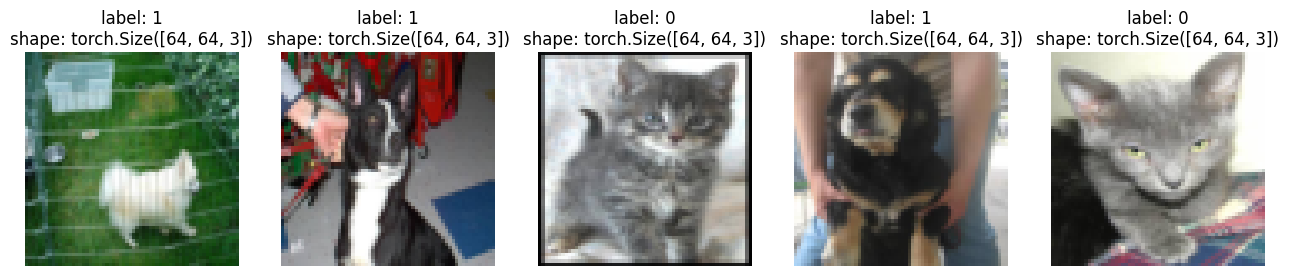

In [26]:
# Displaying Random Images from the TrainDataset

display_random_images(train_dataset, n=5, seed=None)

In [41]:
# Creating Dataloaders for the Train and Test set

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

In [42]:
# Creating the model Class

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [43]:
# Initializing the model

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=1, bias=True)
  )
)

In [44]:
# 1. Get a batch of images and labels from the DataLoader

img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")    

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0746]])

Output prediction probabilities:
tensor([[1.]])

Output prediction label:
tensor([0])

Actual label:
1


In [45]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [56]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).int()
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [57]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y.unsqueeze(1).float())
            test_loss += loss.item()

            test_pred_labels = (torch.sigmoid(test_pred_logits) > 0.5).int()
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [58]:
# Creating a train() function to combine train_step() and test_step()

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model= model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)
        test_loss, test_acc = test_step(model= model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
    return results

In [60]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                            #  lr=0.001), 
                             lr=0.01)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = val_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs= NUM_EPOCHS)

end_time = timer()

print(f"Total Training Time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:07<10:08, 67.56s/it]

Epoch: 1 | train_loss: 0.6951 | train_acc: 16.0592 | test_loss: 0.6935 | test_acc: 15.8408


 20%|██        | 2/10 [02:14<08:59, 67.42s/it]

Epoch: 2 | train_loss: 0.6934 | train_acc: 15.8320 | test_loss: 0.6931 | test_acc: 16.0064


 30%|███       | 3/10 [03:22<07:51, 67.30s/it]

Epoch: 3 | train_loss: 0.6934 | train_acc: 15.8800 | test_loss: 0.6934 | test_acc: 16.0064


 40%|████      | 4/10 [04:28<06:42, 67.16s/it]

Epoch: 4 | train_loss: 0.6933 | train_acc: 16.1136 | test_loss: 0.6935 | test_acc: 15.8408


 50%|█████     | 5/10 [05:36<05:36, 67.21s/it]

Epoch: 5 | train_loss: 0.6934 | train_acc: 15.9728 | test_loss: 0.6931 | test_acc: 16.0064


 60%|██████    | 6/10 [06:42<04:27, 66.96s/it]

Epoch: 6 | train_loss: 0.6936 | train_acc: 15.7264 | test_loss: 0.6932 | test_acc: 15.8408


 70%|███████   | 7/10 [07:49<03:20, 66.93s/it]

Epoch: 7 | train_loss: 0.6934 | train_acc: 15.8000 | test_loss: 0.6933 | test_acc: 15.8408


 80%|████████  | 8/10 [08:57<02:14, 67.15s/it]

Epoch: 8 | train_loss: 0.6935 | train_acc: 15.7776 | test_loss: 0.6932 | test_acc: 15.8408


 90%|█████████ | 9/10 [10:05<01:07, 67.47s/it]

Epoch: 9 | train_loss: 0.6933 | train_acc: 15.8800 | test_loss: 0.6931 | test_acc: 16.0064


100%|██████████| 10/10 [11:12<00:00, 67.24s/it]

Epoch: 10 | train_loss: 0.6934 | train_acc: 15.9056 | test_loss: 0.6934 | test_acc: 15.8408
Total Training Time: 672.361 seconds
